# Import

In [1]:
import matplotlib.pyplot as plt
from PIL import Image
from skimage import img_as_float
import glob
import os
import cv2
from tqdm import tqdm
import numpy as np
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.models import Sequential , load_model
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import collections
from sklearn.utils.class_weight import compute_class_weight
from sklearn.utils import class_weight
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regul


2025-07-14 08:07:49.970513: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752480470.185103      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752480470.245670      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Load Data

In [2]:
def load_data(root_path, img_size=(128, 128), batch_size=32):
    image_paths = glob.glob(os.path.join(root_path, '*/*.jpeg'))

    class_names = sorted(set(os.path.basename(os.path.dirname(p)) for p in image_paths))
    class_to_index = {name: i for i, name in enumerate(class_names)}

    paths = []
    labels = []
    for path in image_paths:
        label_name = os.path.basename(os.path.dirname(path))
        paths.append(path)
        labels.append(class_to_index[label_name])

    dataset = tf.data.Dataset.from_tensor_slices((paths, labels))

    def process(path, label):
        image = tf.io.read_file(path)
        image = tf.image.decode_jpeg(image, channels=3)
        image = tf.image.resize(image, img_size)
        image = tf.cast(image, tf.float32) / 255.0  # Normalize to [0, 1]
        return image, label

    dataset = dataset.map(process)
    dataset = dataset.shuffle(buffer_size=len(paths))  # or 1000
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)


    return dataset, class_names

In [71]:
train_path = "/kaggle/input/chest-xray-pneumonia/chest_xray/train"
val_path = "/kaggle/input/chest-xray-pneumonia/chest_xray/val"
test_path = "/kaggle/input/chest-xray-pneumonia/chest_xray/test"

train_ds, class_names = load_data(train_path, img_size=(128, 128), batch_size=32)
val_ds, _ = load_data(val_path, img_size=(128, 128), batch_size=32)
test_ds, _ = load_data(test_path, img_size=(128, 128), batch_size=32)

print("Classes:", class_names)


Classes: ['NORMAL', 'PNEUMONIA']


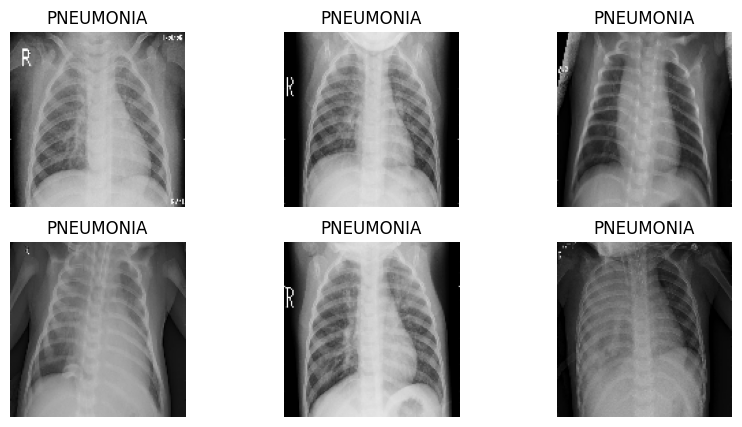

In [4]:
for images, labels in train_ds.take(1):
    plt.figure(figsize=(10, 5))
    for i in range(6): 
        ax = plt.subplot(2, 3, i+1)
        plt.imshow(images[i].numpy())
        plt.title(class_names[labels[i].numpy()])
        plt.axis("off")
    break


# Without augmentation

In [5]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', strides=1, padding='same', input_shape=(128, 128, 3)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(2, activation='softmax')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [6]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     4,194,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,288,834 (16.36 MB)

 Trainable params: 4,288,386 (16.36 MB)

 Non-trainable params: 448 (1.75 KB)

In [7]:
checkpoint = ModelCheckpoint(
    filepath='best_model.h5',        
    monitor='val_loss',               
    save_best_only=True,             
    mode='min',                      
    verbose=1                        
)


In [8]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(
    train_ds,
    validation_data=val_ds,
    callbacks=[checkpoint],
    epochs=15  
)


Epoch 1/15


I0000 00:00:1752480539.102665      96 service.cc:148] XLA service 0x7c652c004cf0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1752480539.103676      96 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1752480539.103700      96 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1752480539.545970      96 cuda_dnn.cc:529] Loaded cuDNN version 90300


  7/163 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.5531 - loss: 11.6532

I0000 00:00:1752480544.017794      96 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


162/163 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8228 - loss: 2.0360
Epoch 1: val_loss improved from inf to 29.20285, saving model to best_model.h5
163/163 ━━━━━━━━━━━━━━━━━━━━ 30s 26ms/step - accuracy: 0.8238 - loss: 2.0187 - val_accuracy: 0.5000 - val_loss: 29.2028
Epoch 2/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9603 - loss: 0.1231
Epoch 2: val_loss improved from 29.20285 to 16.41213, saving model to best_model.h5
163/163 ━━━━━━━━━━━━━━━━━━━━ 21s 21ms/step - accuracy: 0.9603 - loss: 0.1231 - val_accuracy: 0.5000 - val_loss: 16.4121
Epoch 3/15
161/163 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9683 - loss: 0.0985
Epoch 3: val_loss improved from 16.41213 to 3.31569, saving model to best_model.h5
163/163 ━━━━━━━━━━━━━━━━━━━━ 20s 20ms/step - accuracy: 0.9683 - loss: 0.0984 - val_accuracy: 0.5000 - val_loss: 3.3157
Epoch 4/15
161/163 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9691 - loss: 0.0814
Epoch 4: val_loss did not improve from 3.31569
163/163 ━━━

In [9]:
best_model = load_model('best_model.h5')
loss, accuracy = best_model.evaluate(test_ds)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)


20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.7889 - loss: 1.8622
Test Loss: 1.813570261001587
Test Accuracy: 0.7868589758872986


In [10]:
y_true = []
y_pred = []

for images, labels in test_ds:
    preds = np.argmax(best_model.predict(images), axis=1)  
    labels = labels.numpy()                                

    y_true.extend(labels)
    y_pred.extend(preds)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 494ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 506ms/step


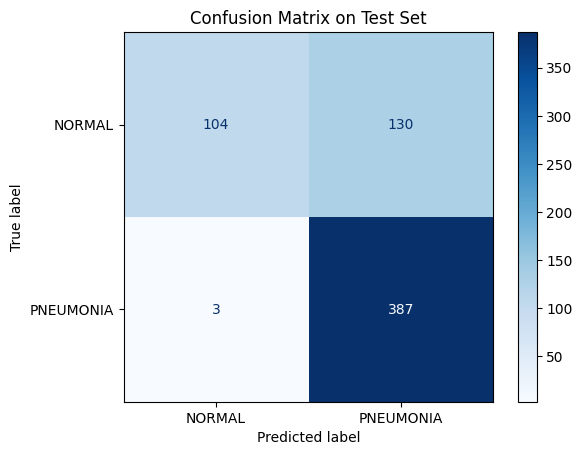

In [11]:
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix on Test Set")
plt.show()


In [12]:
print(classification_report(y_true, y_pred, target_names=class_names))


              precision    recall  f1-score   support

      NORMAL       0.97      0.44      0.61       234
   PNEUMONIA       0.75      0.99      0.85       390

    accuracy                           0.79       624
   macro avg       0.86      0.72      0.73       624
weighted avg       0.83      0.79      0.76       624



# with class weights

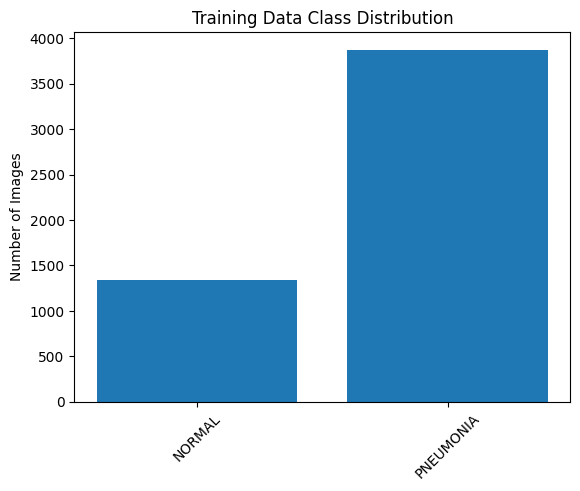

In [13]:
label_counts = collections.Counter()

for _, labels in train_ds:
    label_counts.update(labels.numpy())

# Plot class counts
class_indices = sorted(label_counts.keys())
counts = [label_counts[i] for i in class_indices]

plt.bar([class_names[i] for i in class_indices], counts)
plt.title("Training Data Class Distribution")
plt.ylabel("Number of Images")
plt.xticks(rotation=45)
plt.show()

In [14]:
all_train_labels = []

for _, label in train_ds.unbatch():
    all_train_labels.append(label.numpy())

all_train_labels = np.array(all_train_labels)

In [15]:
labels = [label.numpy() for _, label in train_ds.unbatch()]
labels = np.array(labels)

class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(labels),
    y=labels
)
class_weights = dict(enumerate(class_weights))

print(class_weights)

{0: 1.9448173005219984, 1: 0.6730322580645162}


In [16]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', strides=1, padding='same', input_shape=(128, 128, 3)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(2, activation='softmax')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [17]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy']
)
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,  # adjust as needed
    class_weight=class_weights,
    callbacks=[checkpoint]  )

Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8047 - loss: 2.8715
Epoch 1: val_loss did not improve from 0.09028
163/163 ━━━━━━━━━━━━━━━━━━━━ 26s 24ms/step - accuracy: 0.8052 - loss: 2.8589 - val_accuracy: 0.5000 - val_loss: 24.0986
Epoch 2/10
162/163 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9510 - loss: 0.1244
Epoch 2: val_loss did not improve from 0.09028
163/163 ━━━━━━━━━━━━━━━━━━━━ 20s 21ms/step - accuracy: 0.9510 - loss: 0.1243 - val_accuracy: 0.5000 - val_loss: 23.7055
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9622 - loss: 0.1102
Epoch 3: val_loss did not improve from 0.09028
163/163 ━━━━━━━━━━━━━━━━━━━━ 20s 21ms/step - accuracy: 0.9622 - loss: 0.1101 - val_accuracy: 0.5625 - val_loss: 1.7384
Epoch 4/10
162/163 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9670 - loss: 0.0873
Epoch 4: val_loss did not improve from 0.09028
163/163 ━━━━━━━━━━━━━━━━━━━━ 19s 21ms/step - accuracy: 0.9670 - loss: 0.0874 - val_accuracy: 0.6875 - val

In [18]:
loss, acc = best_model.evaluate(test_ds)
print("Test Loss:", loss)
print("Test Accuracy:", acc)


20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7690 - loss: 2.0274
Test Loss: 1.813570261001587
Test Accuracy: 0.7868589758872986


In [19]:
print(classification_report(y_true, y_pred, target_names=class_names))


              precision    recall  f1-score   support

      NORMAL       0.97      0.44      0.61       234
   PNEUMONIA       0.75      0.99      0.85       390

    accuracy                           0.79       624
   macro avg       0.86      0.72      0.73       624
weighted avg       0.83      0.79      0.76       624



In [20]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(128, 128),
    batch_size=32,
    class_mode='sparse'  
)

Found 5216 images belonging to 2 classes.


# with Augmentation

In [75]:
train_path = "/kaggle/input/chest-xray-pneumonia/chest_xray/train"
val_path = "/kaggle/input/chest-xray-pneumonia/chest_xray/val"
test_path = "/kaggle/input/chest-xray-pneumonia/chest_xray/test"

In [80]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8,1.2],
    fill_mode='nearest',
)

In [81]:
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary',
    subset='training',
    shuffle=True
)

Found 5216 images belonging to 2 classes.


In [82]:
validation_generator = train_datagen.flow_from_directory(
    val_path,
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

Found 16 images belonging to 2 classes.


In [117]:
checkpoint = ModelCheckpoint(
    filepath='best_model.h5',        
    monitor='val_loss',               
    save_best_only=True,             
    mode='min',                      
    verbose=1                        
)


In [118]:
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(128,128,3)),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [119]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples//train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples//validation_generator.batch_size,
    epochs=10,
    class_weight=class_weights,
    callbacks=[checkpoint]
)

Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step - accuracy: 0.5045 - loss: 0.7875
Epoch 1: val_loss improved from inf to 0.46235, saving model to best_model.h5
163/163 ━━━━━━━━━━━━━━━━━━━━ 75s 437ms/step - accuracy: 0.5049 - loss: 0.7868 - val_accuracy: 0.8125 - val_loss: 0.4623
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step - accuracy: 0.8098 - loss: 0.4373
Epoch 2: val_loss did not improve from 0.46235
163/163 ━━━━━━━━━━━━━━━━━━━━ 69s 421ms/step - accuracy: 0.8097 - loss: 0.4373 - val_accuracy: 0.6875 - val_loss: 1.1958
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step - accuracy: 0.8528 - loss: 0.3379
Epoch 3: val_loss did not improve from 0.46235
163/163 ━━━━━━━━━━━━━━━━━━━━ 70s 429ms/step - accuracy: 0.8528 - loss: 0.3380 - val_accuracy: 0.6875 - val_loss: 0.7124
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step - accuracy: 0.8497 - loss: 0.3444
Epoch 4: val_loss did not improve from 0.46235
163/163 ━━━━━━━━━━━━━━━━━━━━ 69s 422ms/step - accuracy: 0.8498 - loss

In [127]:
model.save("best_model.h5")
best_model = load_model("best_model.h5")


In [128]:
loss, acc = best_model.evaluate(test_ds)


20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - accuracy: 0.9286 - loss: 0.2044


In [130]:
y_true = []
y_pred = []

for images, labels in test_ds:
    probs = best_model.predict(images)  # shape (batch_size, 1)
    preds = (probs > 0.5).astype(int).flatten()  # binary labels
    y_true.extend(labels.numpy())
    y_pred.extend(preds)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step


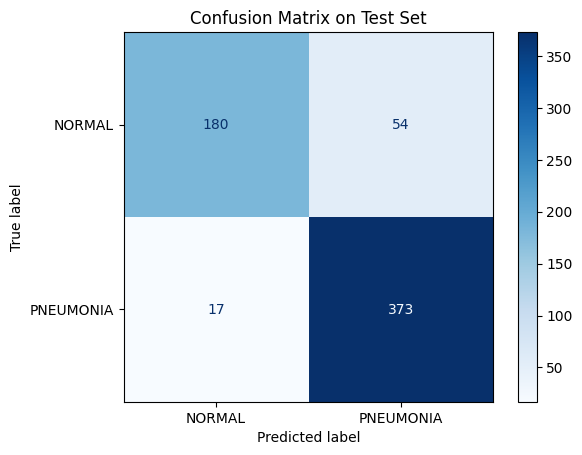

In [131]:
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix on Test Set")
plt.show()



In [132]:
print(classification_report(y_true, y_pred, target_names=class_names))


              precision    recall  f1-score   support

      NORMAL       0.91      0.77      0.84       234
   PNEUMONIA       0.87      0.96      0.91       390

    accuracy                           0.89       624
   macro avg       0.89      0.86      0.87       624
weighted avg       0.89      0.89      0.88       624

